# Max Sharpe Ratio 

- We look till 2024-12 => to see what portfolio gives the best Sharpe once the Tarrifs end and the stock jumps back up

- Tickers: 
    - PLTR, COIN, AAPL, NVDA, TSLA, MCD, KO, TSM, GE

In [29]:
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from sklearn.covariance import LedoitWolf

In [ ]:
# Step 1: Load historical prices
tickers = ['PLTR', 'COIN', 'AAPL', 'NVDA', 'TSLA', 'MCD', 'KO', 'TSM', 'GE']
prices = yf.download(tickers, start='2014-12-31', end='2025-01-01')#['Adj Close'] # pre market crash (from tarrifs)
close = prices['Close']

close

[*********************100%***********************]  9 of 9 completed


Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2014-12-31,24.554003,NaN,103.835754,30.495281,72.242920,0.481179,NaN,14.827333,16.865849
2015-01-02,24.320433,NaN,102.972855,30.437500,71.903656,0.483099,NaN,14.620667,16.790493
2015-01-05,23.635288,NaN,101.082672,30.437500,71.109543,0.474939,NaN,14.006000,16.383539
2015-01-06,23.637512,NaN,98.904907,30.668633,71.240631,0.460540,NaN,14.085333,16.097166
2015-01-07,23.968967,NaN,98.945999,31.051456,72.481941,0.459340,NaN,14.063333,16.330782
...,...,...,...,...,...,...,...,...,...
2024-12-24,257.916443,279.619995,170.893112,62.379669,292.302307,140.207108,82.379997,462.279999,205.529221
2024-12-26,258.735504,274.410004,171.550812,62.111645,293.107666,139.917130,82.139999,454.130005,202.271896
2024-12-27,255.309296,265.709991,169.764145,61.992527,291.934448,136.997391,79.080002,431.660004,200.847458


In [31]:
close.isna().sum() # crypto companies have NaNs which makes sense


Ticker
AAPL       0
COIN    1581
GE         0
KO         0
MCD        0
NVDA       0
PLTR    1447
TSLA       0
TSM        0
dtype: int64

In [ ]:
def log_returns(prices):
    return np.log(prices / prices.shift(1))

returns = close.apply(lambda x: log_returns(x)).dropna() # log returns (what Moelis uses) AKA pct_change 
returns # need to drop 2021 bc it's not complete
returns =returns[returns.index.year>2021]

In [33]:
# average daily return per year
returns.groupby(returns.index.year).mean()

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2022,-0.001221,-0.007827,-0.000461,0.000402,0.000020,-0.002783,-0.004154,-0.004186,-0.001825
2023,0.001595,0.006369,0.002686,-0.000181,0.000561,0.004884,0.003935,0.002807,0.001412
2024,0.001063,0.001413,0.001983,0.000338,0.000005,0.003960,0.005884,0.001927,0.002601


In [34]:
# yearly return per year
returns.groupby(returns.index.year).sum()

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2022,-0.306582,-1.964467,-0.115672,0.100836,0.005068,-0.698454,-1.042553,-1.050723,-0.458051
2023,0.398830,1.592166,0.671476,-0.045359,0.140301,1.220881,0.983746,0.701716,0.352977
2024,0.267775,0.356042,0.499717,0.085053,0.001365,0.997868,1.482689,0.485656,0.655354


In [35]:
# average yearly return 
returns.groupby(returns.index.year).sum().mean()

Ticker
AAPL    0.120008
COIN   -0.005420
GE      0.351840
KO      0.046844
MCD     0.048912
NVDA    0.506765
PLTR    0.474627
TSLA    0.045550
TSM     0.183427
dtype: float64

In [36]:
returns.mean() * 252

Ticker
AAPL    0.120486
COIN   -0.005441
GE      0.353242
KO      0.047030
MCD     0.049106
NVDA    0.508784
PLTR    0.476518
TSLA    0.045731
TSM     0.184157
dtype: float64

In [37]:
returns.corr() # return correlations => good to have uncorrelated stocks together
# that way performanc of two or more doesn't behave similarly
# correaltions are for the most part all < 0.5 which is a good sign

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Ticker,,,,,,,,,
AAPL,1.000000,0.413274,0.391055,0.353318,0.363635,0.561078,0.436844,0.506255,0.476005
COIN,0.413274,1.000000,0.321514,0.078176,0.132629,0.468597,0.527728,0.477417,0.328058
GE,0.391055,0.321514,1.000000,0.197893,0.242852,0.443289,0.356049,0.298589,0.428349
KO,0.353318,0.078176,0.197893,1.000000,0.545925,0.089669,0.049487,0.081976,0.046450
MCD,0.363635,0.132629,0.242852,0.545925,1.000000,0.186412,0.143388,0.158695,0.133189
NVDA,0.561078,0.468597,0.443289,0.089669,0.186412,1.000000,0.505244,0.467663,0.680454
PLTR,0.436844,0.527728,0.356049,0.049487,0.143388,0.505244,1.000000,0.479181,0.405877
TSLA,0.506255,0.477417,0.298589,0.081976,0.158695,0.467663,0.479181,1.000000,0.391673
TSM,0.476005,0.328058,0.428349,0.046450,0.133189,0.680454,0.405877,0.391673,1.000000


In [38]:
# Step 3: Annualized metrics
mean_returns = returns.mean() * 252 # 252 trading days
cov_matrix = returns.cov() * 252

# Optional: Use Ledoit-Wolf shrinkage for a more robust covariance estimate
lw = LedoitWolf()
cov_matrix_shrink = lw.fit(returns).covariance_ * 252


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [39]:
cov_matrix

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Ticker,,,,,,,,,
AAPL,0.073252,0.105861,0.032081,0.014969,0.017077,0.082966,0.080254,0.084351,0.047970
COIN,0.105861,0.895732,0.092233,0.011582,0.021780,0.242301,0.339023,0.278162,0.115607
GE,0.032081,0.092233,0.091874,0.009389,0.012772,0.073409,0.073255,0.055716,0.048343
KO,0.014969,0.011582,0.009389,0.024503,0.014828,0.007669,0.005258,0.007900,0.002707
MCD,0.017077,0.021780,0.012772,0.014828,0.030107,0.017671,0.016888,0.016951,0.008605
NVDA,0.082966,0.242301,0.073409,0.007669,0.017671,0.298492,0.187369,0.157293,0.138423
PLTR,0.080254,0.339023,0.073255,0.005258,0.016888,0.187369,0.460744,0.200235,0.102581
TSLA,0.084351,0.278162,0.055716,0.007900,0.016951,0.157293,0.200235,0.378984,0.089780
TSM,0.047970,0.115607,0.048343,0.002707,0.008605,0.138423,0.102581,0.089780,0.138640


In [40]:
cov_matrix_shrink

array([[0.07519456, 0.10459956, 0.03169834, 0.01479044, 0.01687335,
        0.08197711, 0.07929735, 0.0833456 , 0.04739787],
       [0.10459956, 0.88787049, 0.09113321, 0.01144375, 0.02152048,
        0.23941263, 0.33498181, 0.2748462 , 0.11422905],
       [0.03169834, 0.09113321, 0.09359399, 0.00927748, 0.01262008,
        0.07253405, 0.07238147, 0.05505185, 0.04776717],
       [0.01479044, 0.01144375, 0.00927748, 0.0270266 , 0.01465109,
        0.00757728, 0.00519544, 0.00780551, 0.00267505],
       [0.01687335, 0.02152048, 0.01262008, 0.01465109, 0.03256332,
        0.01746079, 0.01668662, 0.01674934, 0.00850234],
       [0.08197711, 0.23941263, 0.07253405, 0.00757728, 0.01746079,
        0.29774986, 0.18513566, 0.15541839, 0.13677354],
       [0.07929735, 0.33498181, 0.07238147, 0.00519544, 0.01668662,
        0.18513566, 0.45806747, 0.19784841, 0.1013587 ],
       [0.0833456 , 0.2748462 , 0.05505185, 0.00780551, 0.01674934,
        0.15541839, 0.19784841, 0.37728249, 0.08870974],


A covariance matrix provides a measure of how multiple variables (or assets) change together. Specifically, it tells you about the covariance between pairs of variables. Here's what it reveals:

- Covariance Between Variables: The diagonal elements of the matrix show the variance of each individual variable (how much it fluctuates by itself). The off-diagonal elements show the covariance between two variables, which indicates how they move relative to each other.

    - Positive covariance means that as one variable increases, the other tends to increase as well (they move in the same direction).

    - Negative covariance means that as one variable increases, the other tends to decrease (they move in opposite directions).

    - A covariance close to zero means the variables are largely independent of each other in terms of their movements.

- **Magnitude of Relationship**: The magnitude of the covariance tells you the strength of the relationship between the variables. A larger value (positive or negative) indicates a stronger relationship, while a value closer to zero suggests a weaker or no linear relationship.

- **Multivariate Risk**: In finance, for example, the covariance matrix helps in understanding the **overall portfolio risk**. It shows how the returns of different assets in the portfolio are correlated, which is crucial when constructing portfolios that aim to balance risk through diversification.

In [41]:
# Step 4: Efficient Frontier
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) # prtfolio returns
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) # portfolio std
    return returns, std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.03):
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std # negative Sharpe

def constraint(weights):
    return np.sum(weights) - 1


# Optimization settings
bounds = [(0, 1) for _ in tickers]
initial_guess = np.array([1/len(tickers)] * len(tickers)) #  initial portfolio weights
constraints = {'type': 'eq', 'fun': constraint}

# Solve for max Sharpe using shrinkage covariance
opt = minimize(negative_sharpe, initial_guess, args=(mean_returns, cov_matrix_shrink), 
               method='SLSQP', bounds=bounds, constraints=constraints)

# Print optimal weights and maximum Sharpe ratio
for i,ticker in enumerate(tickers):
    print(f"{ticker}: %{opt.x[i]*100:.16f}")

# print('Optimal weights:', opt.x*100)

print('\nMaximum Sharpe ratio:', -opt.fun)

PLTR: %0.0000000000000231
COIN: %0.0000000000000000
AAPL: %71.5598977653667845
NVDA: %0.0000000000000240
TSLA: %0.0000000000000207
MCD: %22.3723945001382916
KO: %6.0677077344950048
TSM: %0.0000000000000000
GE: %0.0000000000000000

Maximum Sharpe ratio: 1.1613818775797324


Optimal Returns: 39.55% with volatility of 0.3147289922634373


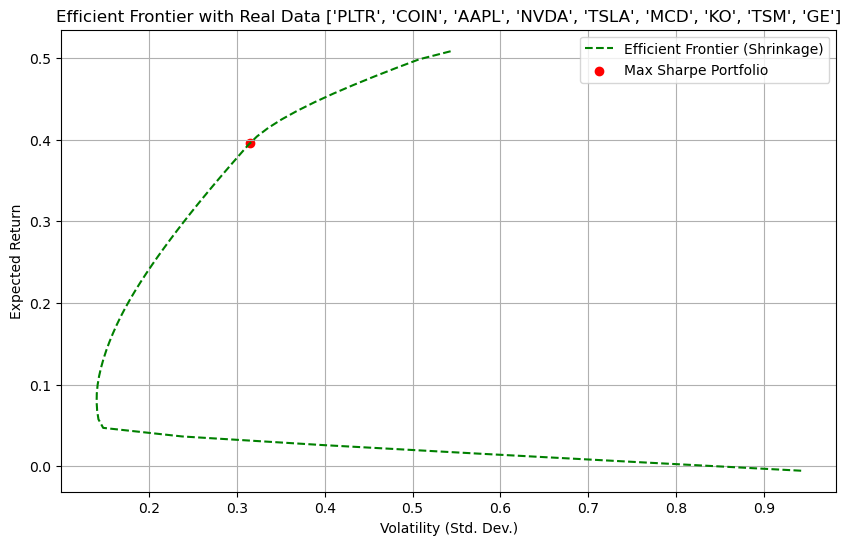

In [42]:
# this focuses on bear and bullish years (2022, 2023, 2024)
# 2022 was overall bad (negatif), 2023 and 2024 were very positive => might be more realistic taking into account what we're seeing in 2025
# Build efficient Frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
frontier_vol = []

for r in target_returns:
    cons = [{'type': 'eq', 'fun': constraint},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - r}]
    result = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix_shrink, w))),
                      initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    if result.success:
        frontier_vol.append(result.fun)
    else:
        frontier_vol.append(np.nan)


# Plot

optim_ret, optim_vol = portfolio_performance(opt.x, mean_returns, cov_matrix_shrink)

print(f'Optimal Returns: {np.round(optim_ret*100,2)}% with volatility of {optim_vol}')

plt.figure(figsize=(10, 6))
plt.plot(frontier_vol, target_returns, label='Efficient Frontier (Shrinkage)', linestyle='--', color='green')
plt.scatter(optim_vol, optim_ret, color='red', label='Max Sharpe Portfolio')
plt.xlabel('Volatility (Std. Dev.)')
plt.ylabel('Expected Return')
plt.title(f'Efficient Frontier with Real Data {tickers}')
plt.legend()
plt.grid(True)
plt.show()

In [48]:
returns.groupby(returns.index.year).nunique()

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2022,251,251,251,251,251,251,250,251,251
2023,250,250,250,248,250,250,245,250,250
2024,252,252,250,248,252,252,252,252,252


In [ ]:
returns
window_sizes = [251, 250, 252]
# for i in range(len(returns) - window_size):
#     print(i)

window_sizes = [251, 250, 252]

In [53]:

# Define annualized Sharpe ratio optimization
def get_max_sharpe_with_weights(returns_window, risk_free_rate=0.03):
    mean_returns = returns_window.mean() * 252
    cov_matrix = returns_window.cov() * 252
    num_assets = len(mean_returns)

    def sharpe_ratio(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(port_return - risk_free_rate) / port_vol

    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1) for _ in range(num_assets)]
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        max_sharpe = -result.fun
        weights = result.x
        return max_sharpe, weights
    else:
        return np.nan, [np.nan] * num_assets

# Rolling window Sharpe ratio
window_size = 252  # roughly one trading year
rolling_sharpes = []
rolling_weights = []
dates = []

for i in range(len(returns) - window_size):
    window = returns.iloc[i:i + window_size]
    sharpe, weights = get_max_sharpe_with_weights(window)
    rolling_sharpes.append(sharpe)
    rolling_weights.append(weights)
    dates.append(returns.index[i + window_size])




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


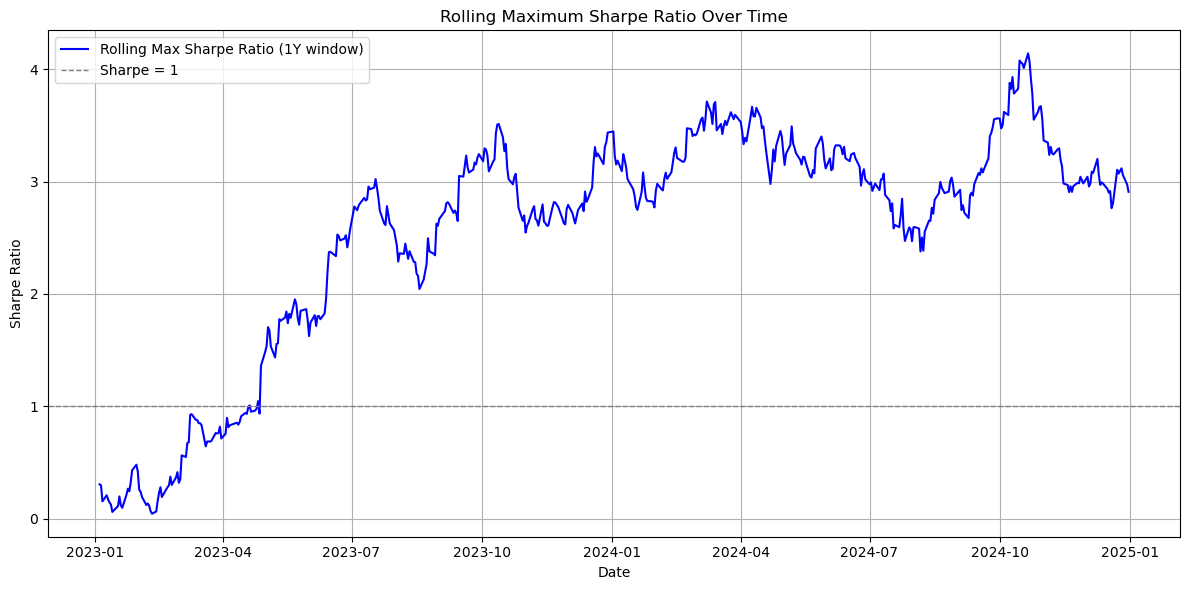

In [54]:
# Plotting the rolling Sharpe ratio
plt.figure(figsize=(12, 6))
plt.plot(dates, rolling_sharpes, label='Rolling Max Sharpe Ratio (1Y window)', color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='Sharpe = 1')
plt.title('Rolling Maximum Sharpe Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [55]:
weights_df = pd.DataFrame(rolling_weights, index=dates, columns=returns.columns)
weights_df.head()

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
2023-01-04,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-01-05,3.309646e-10,4.512256e-10,9.275219e-09,1.0,9.141673e-10,3.386807e-09,3.476388e-10,3.497678e-10,2.622553e-10
2023-01-06,2.289962e-09,1.991745e-09,2.072535e-07,1.0,2.004924e-09,8.689218e-09,1.570630e-09,1.561426e-09,1.234799e-09
2023-01-09,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2023-01-10,2.474375e-09,1.596569e-09,1.082144e-07,1.0,1.525910e-09,1.395521e-08,1.274517e-09,1.264156e-09,1.018953e-09


<Figure size 1400x800 with 0 Axes>

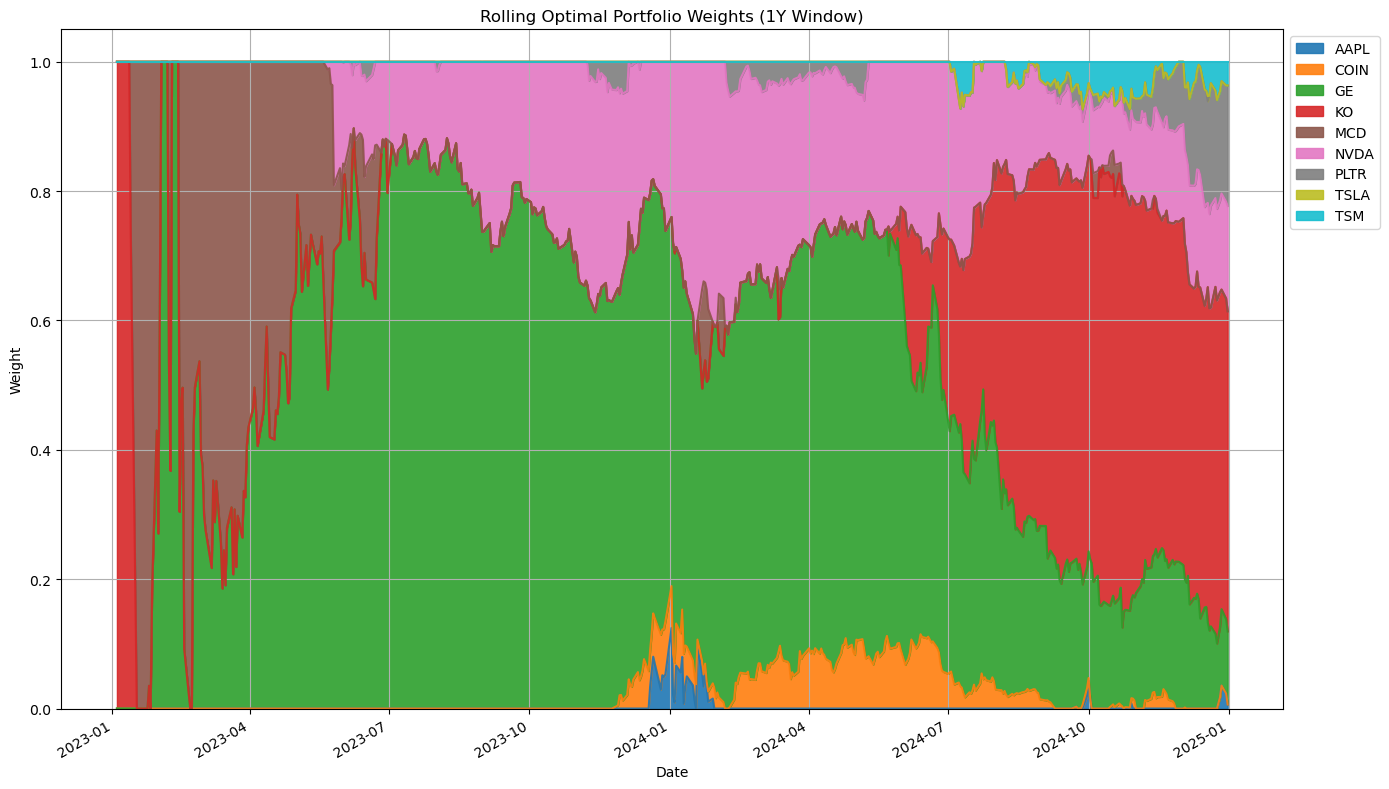

In [56]:
plt.figure(figsize=(14, 8))
weights_df.plot.area(stacked=True, figsize=(14, 8), colormap='tab10', alpha=0.9)
plt.title("Rolling Optimal Portfolio Weights (1Y Window)")
plt.xlabel("Date")
plt.ylabel("Weight")
plt.legend(loc='upper left', bbox_to_anchor=(1.0, 1.0))
plt.grid(True)
plt.tight_layout()
plt.show()

In [49]:
rolling_sharpes[:5]

[0.3057923053915048,
 0.2956917313974289,
 0.15386222441302394,
 0.2080946991667132,
 0.17112434409152652]

In [ ]:
np.mean(rolling_sharpes) # mean Sharpe is 2.55 - rolling

2.5553189600963364

In [51]:
window_size = 252
i = 0
window = returns.iloc[i:i + window_size]

In [52]:
window

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2022-01-03,0.024696,-0.005244,0.018563,0.001519,0.001901,0.023854,0.017420,0.126912,0.068189
2022-01-04,-0.012773,-0.003591,0.032005,0.016557,-0.000261,-0.027976,-0.019619,-0.042733,0.035091
2022-01-05,-0.026960,-0.065757,0.000000,0.008259,-0.004928,-0.059285,-0.068914,-0.054954,-0.048693
2022-01-06,-0.016834,-0.000982,0.005820,-0.005278,0.009313,0.020581,-0.013057,-0.021758,0.011036
2022-01-07,0.000988,-0.007162,0.014403,-0.002318,-0.009800,-0.033598,-0.010811,-0.036090,-0.039454
...,...,...,...,...,...,...,...,...,...
2022-12-27,-0.013976,-0.083406,0.012756,0.006092,-0.002732,-0.074027,-0.047202,-0.121138,-0.007640
2022-12-28,-0.031166,-0.003682,-0.010558,-0.010017,-0.006504,-0.006038,0.011599,0.032553,-0.017099
2022-12-29,0.027931,0.066880,0.021483,0.005960,0.003088,0.039602,0.052939,0.077726,0.039452


In [ ]:
mean_returns = returns_window.mean() * 252
cov_matrix = returns_window.cov() * 252
num_assets = len(mean_returns)

def sharpe_ratio(weights):
    port_return = np.dot(weights, mean_returns)
    port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return -(port_return - risk_free_rate) / port_vol

constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
bounds = [(0, 1) for _ in range(num_assets)]
init_guess = np.ones(num_assets) / num_assets

result = minimize(sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)

In [58]:
returns.iloc[0]

Ticker
AAPL    0.024696
COIN   -0.005244
GE      0.018563
KO      0.001519
MCD     0.001901
NVDA    0.023854
PLTR    0.017420
TSLA    0.126912
TSM     0.068189
Name: 2022-01-03 00:00:00, dtype: float64

In [59]:
# Re-import necessary packages after code state reset
import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize

# Define tickers and date range
tickers = ['PLTR', 'COIN', 'AAPL', 'NVDA', 'TSLA', 'MCD', 'KO', 'TSM', 'GE']
start_date = '2021-04-15'
end_date = '2024-12-31'

# Download adjusted close prices
data = yf.download(tickers, start=start_date, end=end_date)
close = data['Close']

# Calculate daily returns
returns = close.apply(lambda x: log_returns(x)).dropna() # log returns (what Moelis uses) AKA pct_change 


# Define portfolio optimization to maximize Sharpe ratio
def max_sharpe_portfolio(returns_window, risk_free_rate=0.03):
    mean_returns = returns_window.mean() * 252
    cov_matrix = returns_window.cov() * 252
    num_assets = len(mean_returns)

    def sharpe_ratio(w):
        port_return = np.dot(w, mean_returns)
        port_vol = np.sqrt(np.dot(w.T, np.dot(cov_matrix, w)))
        return -(port_return - risk_free_rate) / port_vol

    constraints = ({'type': 'eq', 'fun': lambda w: np.sum(w) - 1})
    bounds = tuple((0, 1) for _ in range(num_assets))
    init_guess = num_assets * [1. / num_assets]

    result = minimize(sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    return result.x

# Rolling optimization
rolling_window = 63  # ~3 months
portfolio_returns = []

for i in range(rolling_window, len(returns)):
    window_data = returns.iloc[i - rolling_window:i]
    weights = max_sharpe_portfolio(window_data)
    daily_ret = np.dot(weights, returns.iloc[i])
    portfolio_returns.append(daily_ret)




[*********************100%***********************]  9 of 9 completed


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [ ]:
portfolio_returns = pd.Series(portfolio_returns, index=returns.index[rolling_window:])



Date
2021-07-16   -0.010633
2021-07-19   -0.006289
2021-07-20   -0.002571
2021-07-21    0.021592
2021-07-22    0.003589
                ...   
2024-12-23    0.008675
2024-12-24    0.019759
2024-12-26   -0.002226
2024-12-27   -0.025351
2024-12-30   -0.018335
Length: 870, dtype: float64

In [66]:
portfolio_returns.head()

Date
2021-07-16   -0.010633
2021-07-19   -0.006289
2021-07-20   -0.002571
2021-07-21    0.021592
2021-07-22    0.003589
dtype: float64

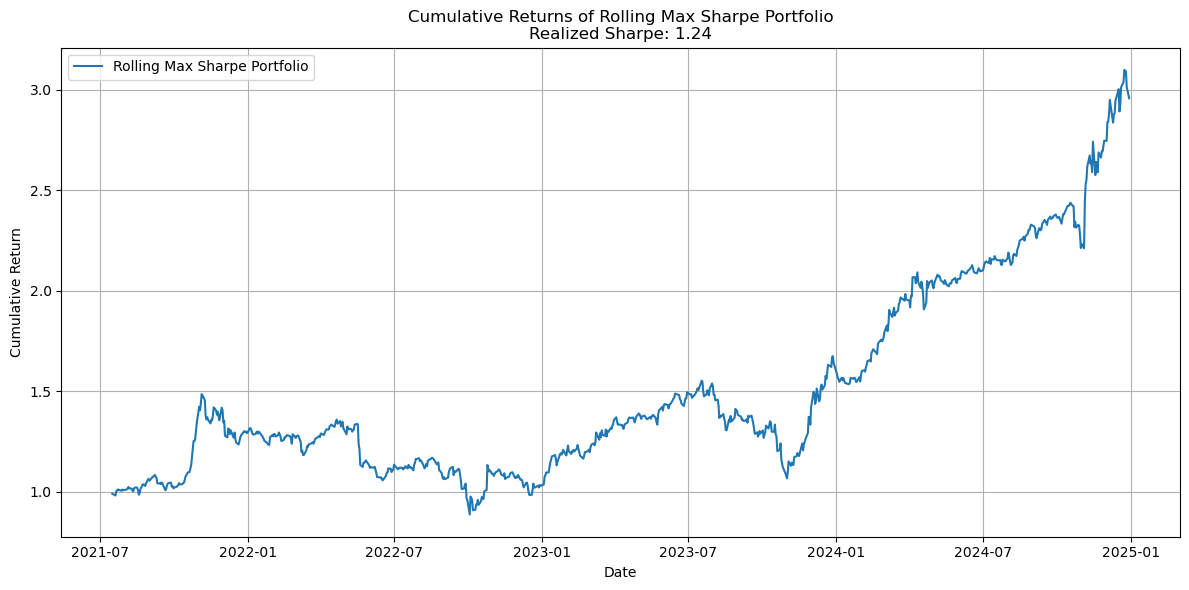

In [64]:

# Calculate cumulative performance and Sharpe
cumulative_returns = (1 + portfolio_returns).cumprod()
realized_sharpe = (portfolio_returns.mean() * 252) / (portfolio_returns.std() * np.sqrt(252))

# Plot results
plt.figure(figsize=(12, 6))
plt.plot(cumulative_returns, label='Rolling Max Sharpe Portfolio')
plt.title(f'Cumulative Returns of Rolling Max Sharpe Portfolio\nRealized Sharpe: {realized_sharpe:.2f}')
plt.ylabel('Cumulative Return')
plt.xlabel('Date')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [65]:
realized_sharpe

1.2375193031717862

# What if we focus on 2023 and 2024 only

In [51]:
returns_23_24 = returns[returns.index.year >=2023].copy()
returns_23_24

Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Date,,,,,,,,,
2023-01-03,-0.038122,-0.051903,0.014102,-0.010430,0.003031,-0.020672,-0.004684,-0.130590,-0.006195
2023-01-04,0.010261,0.115134,0.056573,-0.000477,0.000227,0.029867,0.029300,0.049979,0.030464
2023-01-05,-0.010661,-0.117220,0.015408,-0.011509,-0.008470,-0.033366,-0.040315,-0.029469,-0.007761
2023-01-06,0.036134,-0.008085,0.009076,0.019109,0.027502,0.040797,0.012579,0.024352,0.030432
2023-01-09,0.004080,0.140311,0.010096,-0.012539,-0.008272,0.050458,0.015504,0.057655,0.028288
...,...,...,...,...,...,...,...,...,...
2024-12-24,0.011413,0.041885,0.014508,0.007347,0.009226,0.003930,0.020728,0.070991,-0.004980
2024-12-26,0.003171,-0.018808,0.003841,-0.004306,0.002751,-0.002070,-0.002918,-0.017787,-0.015975
2024-12-27,-0.013331,-0.032218,-0.010469,-0.001920,-0.004011,-0.021088,-0.037965,-0.050745,-0.007067


In [52]:
mean_returns = returns_23_24.mean() * 252 # 252 trading days
cov_matrix = returns_23_24.cov() * 252

# Optional: Use Ledoit-Wolf shrinkage for a more robust covariance estimate
lw = LedoitWolf()
cov_matrix_shrink = lw.fit(returns_23_24).covariance_ * 252


cov_matrix

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Ticker,AAPL,COIN,GE,KO,MCD,NVDA,PLTR,TSLA,TSM
Ticker,,,,,,,,,
AAPL,0.046040,0.042941,0.012785,0.004161,0.007584,0.037334,0.042625,0.049310,0.024841
COIN,0.042941,0.744054,0.057400,-0.003237,0.012366,0.131238,0.217840,0.187920,0.061392
GE,0.012785,0.057400,0.075473,0.000503,0.002761,0.045778,0.049997,0.036371,0.035064
KO,0.004161,-0.003237,0.000503,0.017279,0.009955,-0.009185,-0.002737,-0.003025,-0.006375
MCD,0.007584,0.012366,0.002761,0.009955,0.025674,0.000806,0.009505,0.008881,0.000585
NVDA,0.037334,0.131238,0.045778,-0.009185,0.000806,0.244580,0.107425,0.089681,0.114051
PLTR,0.042625,0.217840,0.049997,-0.002737,0.009505,0.107425,0.413173,0.140399,0.075386
TSLA,0.049310,0.187920,0.036371,-0.003025,0.008881,0.089681,0.140399,0.340571,0.060975
TSM,0.024841,0.061392,0.035064,-0.006375,0.000585,0.114051,0.075386,0.060975,0.127140


In [53]:
# Step 4: Efficient Frontier
def portfolio_performance(weights, mean_returns, cov_matrix):
    returns = np.dot(weights, mean_returns) # prtfolio returns
    std = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights))) # portfolio std
    return returns, std

def negative_sharpe(weights, mean_returns, cov_matrix, risk_free_rate=0.03):
    p_return, p_std = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(p_return - risk_free_rate) / p_std # negative Sharpe

def constraint(weights):
    return np.sum(weights) - 1


# Optimization settings
bounds = [(0, 1) for _ in tickers]
initial_guess = np.array([1/len(tickers)] * len(tickers)) #  initial portfolio weights
constraints = {'type': 'eq', 'fun': constraint}

# Solve for max Sharpe using shrinkage covariance
opt = minimize(negative_sharpe, initial_guess, args=(mean_returns, cov_matrix_shrink), 
               method='SLSQP', bounds=bounds, constraints=constraints)

# Print optimal weights and maximum Sharpe ratio
for i,ticker in enumerate(tickers):
    print(f"{ticker}: %{opt.x[i]*100:.16f}")

# print('Optimal weights:', opt.x*100)

print('\nMaximum Sharpe ratio:', -opt.fun)

PLTR: %15.6113455444945952
COIN: %0.0000000000000016
AAPL: %39.9489136802681699
NVDA: %4.2462904825124284
TSLA: %0.0000000000000009
MCD: %25.5781128355068113
KO: %14.6153374572179953
TSM: %0.0000000000000011
GE: %0.0000000000000000

Maximum Sharpe ratio: 2.789071473675233


- Very different from before 
    - last two years, crypto doing well, larger Sharpe

Optimal Returns: 75.38% with volatility of 0.25951374269969324


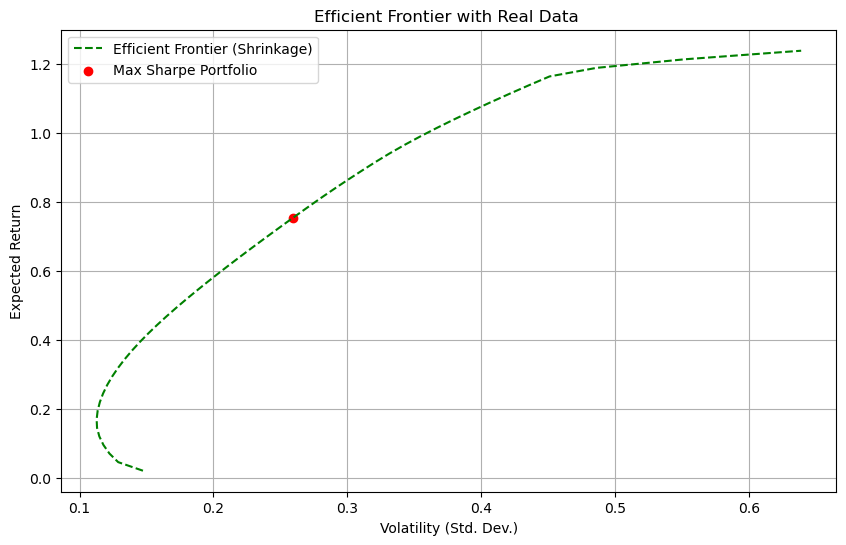

In [54]:
# This is focused on Bullish Years (2023, 2024)
# Build efficient Frontier
target_returns = np.linspace(mean_returns.min(), mean_returns.max(), 50)
frontier_vol = []

for r in target_returns:
    cons = [{'type': 'eq', 'fun': constraint},
            {'type': 'eq', 'fun': lambda w: np.dot(w, mean_returns) - r}]
    result = minimize(lambda w: np.sqrt(np.dot(w.T, np.dot(cov_matrix_shrink, w))),
                      initial_guess, method='SLSQP', bounds=bounds, constraints=cons)
    if result.success:
        frontier_vol.append(result.fun)
    else:
        frontier_vol.append(np.nan)


# Plot

optim_ret, optim_vol = portfolio_performance(opt.x, mean_returns, cov_matrix_shrink)


print(f'Optimal Returns: {np.round(optim_ret*100,2)}% with volatility of {optim_vol}')

plt.figure(figsize=(10, 6))
plt.plot(frontier_vol, target_returns, label='Efficient Frontier (Shrinkage)', linestyle='--', color='green')
plt.scatter(optim_vol, optim_ret, color='red', label='Max Sharpe Portfolio')
plt.xlabel('Volatility (Std. Dev.)')
plt.ylabel('Expected Return')
plt.title('Efficient Frontier with Real Data ')
plt.legend()
plt.grid(True)
plt.show()

In [55]:

# Define annualized Sharpe ratio optimization
def get_max_sharpe(returns_window, risk_free_rate=0.03):
    mean_returns = returns_window.mean() * 252
    cov_matrix = returns_window.cov() * 252
    num_assets = len(mean_returns)

    def sharpe_ratio(weights):
        port_return = np.dot(weights, mean_returns)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
        return -(port_return - risk_free_rate) / port_vol

    constraints = {'type': 'eq', 'fun': lambda w: np.sum(w) - 1}
    bounds = [(0, 1) for _ in range(num_assets)]
    init_guess = np.ones(num_assets) / num_assets

    result = minimize(sharpe_ratio, init_guess, method='SLSQP', bounds=bounds, constraints=constraints)
    if result.success:
        max_sharpe = -result.fun
    else:
        max_sharpe = np.nan
    return max_sharpe

# Rolling window Sharpe ratio
window_size = 252  # roughly one trading year
rolling_sharpes = []
dates = []

for i in range(len(returns_23_24) - window_size):
    window = returns_23_24.iloc[i:i + window_size]
    sharpe = get_max_sharpe(window)
    rolling_sharpes.append(sharpe)
    dates.append(returns_23_24.index[i + window_size])




Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


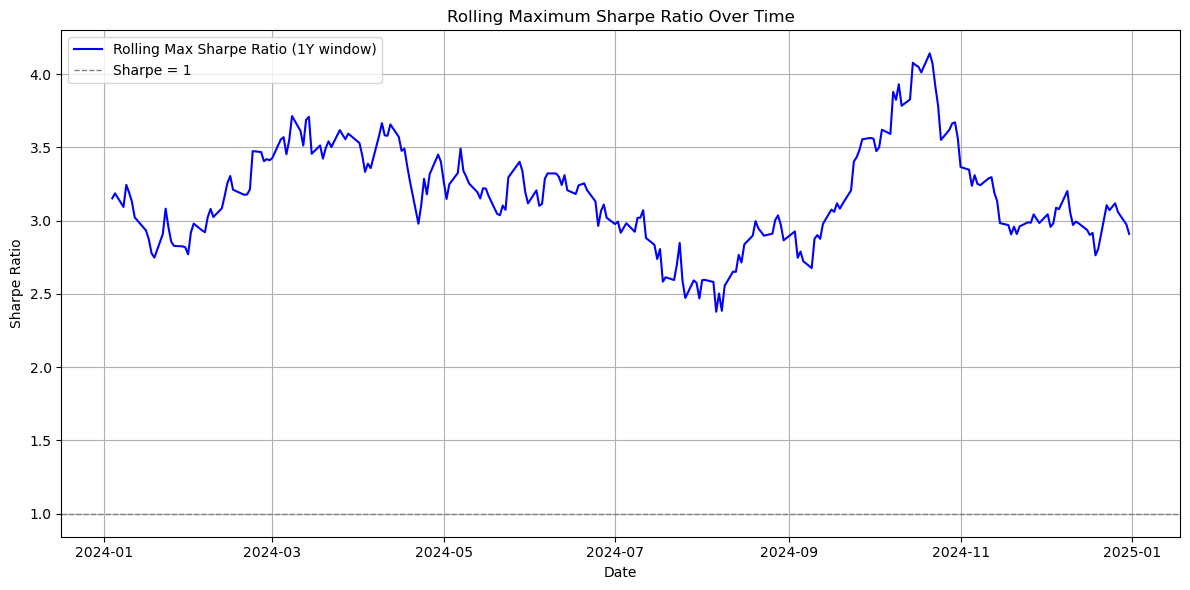

In [56]:
# Plotting the rolling Sharpe ratio
plt.figure(figsize=(12, 6))
plt.plot(dates, rolling_sharpes, label='Rolling Max Sharpe Ratio (1Y window)', color='blue')
plt.axhline(y=1.0, color='gray', linestyle='--', linewidth=1, label='Sharpe = 1')
plt.title('Rolling Maximum Sharpe Ratio Over Time')
plt.xlabel('Date')
plt.ylabel('Sharpe Ratio')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

- so in 2024 we have some really strong Sharpes